# TensorTrade - Renderers and Plotly Visualization Chart
## Data Loading Function

In [1]:
!pip install /tensortrade -U

Processing /tensortrade
  Preparing metadata (setup.py) ... done


  Created wheel for tensortrade: filename=tensortrade-1.0.4.dev1-py3-none-any.whl size=136444 sha256=faf2fbbeb8c0d36d601dc2b3371e4634651e21b628cf6e8010c651a412d2d778
  Stored in directory: /tmp/pip-ephem-wheel-cache-t6j349xp/wheels/5c/80/0b/07e46799e19c54c3244190ea08f82534ab3fbdbd4fad3de846
Successfully built tensortrade
  Attempting uninstall: tensortrade
    Found existing installation: tensortrade 1.0.4.dev1
    Uninstalling tensortrade-1.0.4.dev1:
      Successfully uninstalled tensortrade-1.0.4.dev1


In [2]:
# ipywidgets is required to run Plotly in Jupyter Notebook.
# Uncomment and run the following line to install it if required.

#!pip install ipywidgets

In [3]:
import ta

import pandas as pd

from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio

%matplotlib inline

2023-02-26 22:43:23.960196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 22:43:24.096710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-26 22:43:24.096758: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-26 22:43:24.755515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp form "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    # Convert the date column type from string to datetime for proper sorting.
    df['date'] = pd.to_datetime(df['date'])

    # Make sure historical prices are sorted chronologically, oldest first.
    df.sort_values(by='date', ascending=True, inplace=True)

    df.reset_index(drop=True, inplace=True)

    # Format timestamps as you want them to appear on the chart buy/sell marks.
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')

    return df

In [5]:
#df = load_csv('Bitfinex_BTCUSD_1h.csv')
df = load_csv('Coinbase_BTCUSD_1h.csv')
df.head()

,date,open,high,low,close,volume
0,2017-07-01 11:00 AM,2505.56,2513.38,2495.12,2509.17,287000.32
1,2017-07-01 12:00 PM,2509.17,2512.87,2484.99,2488.43,393142.50
2,2017-07-01 01:00 PM,2488.43,2488.43,2454.40,2454.43,693254.01
3,2017-07-01 02:00 PM,2454.43,2473.93,2450.83,2459.35,712864.80
4,2017-07-01 03:00 PM,2459.35,2475.00,2450.00,2467.83,682105.41


## Data Preparation
### Create the dataset features

In [6]:
dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
dataset.head(3)

/usr/local/lib/python3.8/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2017-07-01 11:00 AM,2505.56,2513.38,2495.12,2509.17,287000.32,154659.537174,287000.32,0.538883,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2509.170000,-65.047642,0.000000,0.000000
1,2017-07-01 12:00 PM,2509.17,2512.87,2484.99,2488.43,393142.50,-141466.449196,-106142.18,-0.207995,-8.153775e+06,...,-0.065977,-0.013195,-0.052782,2.871568,0.574314,2.297254,2500.178580,-0.826568,-0.830003,-0.826568
2,2017-07-01 01:00 PM,2488.43,2488.43,2454.40,2454.43,693254.01,-833498.148276,-799396.19,-0.606888,-1.035618e+07,...,-0.225431,-0.055643,-0.169789,12.006246,2.860700,9.145546,2480.168753,-1.366323,-1.375743,-2.181598


### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [7]:
price_history = dataset[['date', 'open', 'high', 'low', 'close', 'volume']]  # chart data
display(price_history.head(3))

dataset.drop(columns=['date', 'open', 'high', 'low', 'close', 'volume'], inplace=True)

,date,open,high,low,close,volume
0,2017-07-01 11:00 AM,2505.56,2513.38,2495.12,2509.17,287000.32
1,2017-07-01 12:00 PM,2509.17,2512.87,2484.99,2488.43,393142.50
2,2017-07-01 01:00 PM,2488.43,2488.43,2454.40,2454.43,693254.01


## Setup Trading Environment
### Create Data Feeds

In [8]:
bitfinex = Exchange("bitfinex", service=execute_order)(
    Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-BTC")
)

portfolio = Portfolio(USD, [
    Wallet(bitfinex, 10000 * USD),
    Wallet(bitfinex, 10 * BTC),
])

with NameSpace("bitfinex"):
    streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

feed = DataFeed(streams)
feed.next()

{'bitfinex:/volume_adi': 154659.5371741516,
 'bitfinex:/volume_obv': 287000.32,
 'bitfinex:/volume_cmf': 0.5388828039430464,
 'bitfinex:/volume_fi': 0.0,
 'bitfinex:/volume_em': 0.0,
 'bitfinex:/volume_sma_em': 0.0,
 'bitfinex:/volume_vpt': -187039.68188942783,
 'bitfinex:/volume_vwap': 2505.89,
 'bitfinex:/volume_mfi': 50.0,
 'bitfinex:/volume_nvi': 1000.0,
 'bitfinex:/volatility_bbm': 2509.17,
 'bitfinex:/volatility_bbh': 2509.17,
 'bitfinex:/volatility_bbl': 2509.17,
 'bitfinex:/volatility_bbw': 0.0,
 'bitfinex:/volatility_bbp': 0.0,
 'bitfinex:/volatility_bbhi': 0.0,
 'bitfinex:/volatility_bbli': 0.0,
 'bitfinex:/volatility_kcc': 2505.89,
 'bitfinex:/volatility_kch': 2524.15,
 'bitfinex:/volatility_kcl': 2487.6299999999997,
 'bitfinex:/volatility_kcw': 1.457366444656407,
 'bitfinex:/volatility_kcp': 0.5898138006571786,
 'bitfinex:/volatility_kchi': 0.0,
 'bitfinex:/volatility_kcli': 0.0,
 'bitfinex:/volatility_dcl': 2495.12,
 'bitfinex:/volatility_dch': 2513.38,
 'bitfinex:/volatil

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Trading Environment with a Single Renderer

In [9]:
import tensortrade.env.default as default

env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=feed,
    renderer="screen-log",  # ScreenLogger used with default settings
    window_size=20
)

In [10]:
#from tensortrade.agents import DQNAgent

#agent = DQNAgent(env)
#agent.train(n_episodes=2, n_steps=200, render_interval=10)

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

In [11]:
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

chart_renderer = PlotlyTradingChart(
    display=True,  # show the chart on screen (default)
    height=800,  # affects both displayed and saved file height. None for 100% height.
    save_format="html",  # save the chart to an HTML file
    auto_open_html=True,  # open the saved HTML chart in a new browser tab
)

file_logger = FileLogger(
    filename="example.log",  # omit or None for automatic file name
    path="training_logs"  # create a new directory if doesn't exist, None for no directory
)

### Environement with Multiple Renderers

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

In [12]:
renderer_feed = DataFeed([
    Stream.source(price_history[c].tolist(), dtype="float").rename(c) for c in price_history]
)

env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=feed,
    window_size=20,
    renderer_feed=renderer_feed,
    renderer=[
        chart_renderer, 
        file_logger
    ]
)

In [13]:
renderer_feed

## Setup and Train DQN Agent
The green and red arrows shown on the chart represent buy and sell trades respectively. The head of each arrow falls at the trade execution price.

In [14]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)

# Set render_interval to None to render at episode ends only
agent.train(n_episodes=2, n_steps=200, render_interval=10)

/tmp/ipykernel_348/1440734842.py:3: DeprecationWarning: Call to deprecated class DQNAgent. (Builtin agents are being deprecated in favor of external implementations (ie: Ray)) -- Deprecated since version 1.0.4.
  agent = DQNAgent(env)
2023-02-26 22:43:33.613972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-26 22:43:33.614031: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-26 22:43:33.614067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4943dccc203e): /proc/driver/nvidia/version does not exist
2023-02-26 22:43:33.614302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the f

====      AGENT ID: d98ca1a7-1265-494f-a48e-1796a0e374c7      ====


NoneType: None


FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candlestick',
              'uid': '837cb0e7-df45-40d7-a1b2-f432349c8f22',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'marker': {'color': 'DodgerBlue'},
              'name': 'Volume',
              'showlegend': False,
              'type': 'bar',
              'uid': '6364f9f6-ee5c-46a6-9446-81457ebb0515',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'mode': 'lines',
              'name': 'bitfinex:/USD-BTC',
              'type': 'scatter',
              'uid': 'c96d0e66-7437-41a4-8c9c-5d805c0010c0',
              'xaxis': 'x3',
              'yaxis': 'y3'},
             {'mode': 'lines',
              'name': 'bitfinex:/USD:/free',
              'type': 'scatter',
              'uid': 'a8c5fa5d-f7a1-4bce-a0cf-7ce00817e675',
              'xaxis': 'x3',
              'yaxis': 'y3'},
             {'mode': 'lines',
            

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:43:52] Episode: 2/2 Step: 11/200 - Performance:
    bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0             2509.17              10000.0                    0.0   
1             2488.43                  0.0                    0.0   
2             2454.43                  0.0                    0.0   
3             2459.35                  0.0                    0.0   
4             2467.83                  0.0                    0.0   
5             2460.01                  0.0                    0.0   
6             2445.99                  0.0                    0.0   
7             2425.94                  0.0                    0.0   
8             2435.99                  0.0                    0.0   
9             2408.25                  0.0                    0.0   
10            2416.62                  0.0                    0.0   

    bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfinex:/BTC:/lock

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62]),
              'high': array([2513.38, 2512.87, 2488.43, 2473.93, 2475.  , 2469.99, 2460.68, 2455.86,
                             2437.86, 2438.95, 2420.  ]),
              'low': array([2495.12, 2484.99, 2454.4 , 2450.83, 2450.  , 2450.  , 2428.03, 2414.  ,
                            2406.44, 2404.61, 2401.  ]),
              'name': 'Price',
              'open': array([2505.56, 2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99,
                             2425.94, 2435.99, 2408.25]),
              'showlegend': False,
              'type': 'candlestick',
              'uid': '837cb0e7-df45-40d7-a1b2-f432349c8f22',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'marker': {'color': 'DodgerBlue'},
              'name': 'Volume',
              'showlegend': False,
            

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:43:59] Episode: 2/2 Step: 21/200 - Performance:
    bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0             2509.17              10000.0                    0.0   
1             2488.43                  0.0                    0.0   
2             2454.43                  0.0                    0.0   
3             2459.35                  0.0                    0.0   
4             2467.83                  0.0                    0.0   
5             2460.01                  0.0                    0.0   
6             2445.99                  0.0                    0.0   
7             2425.94                  0.0                    0.0   
8             2435.99                  0.0                    0.0   
9             2408.25                  0.0                    0.0   
10            2416.62                  0.0                    0.0   
11            2424.99                  0.0                    0.0  

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95]),
              'high': array([2513.38, 2512.87, 2488.43, 2473.93, 2475.  , 2469.99, 2460.68, 2455.86,
                             2437.86, 2438.95, 2420.  , 2425.  , 2431.94, 2426.  , 2419.9 , 2411.  ,
                             2410.  , 2412.  , 2439.99, 2439.99, 2439.97]),
              'low': array([2495.12, 2484.99, 2454.4 , 2450.83, 2450.  , 2450.  , 2428.03, 2414.  ,
                            2406.44, 2404.61, 2401.  , 2400.  , 2414.8 , 2389.99, 2385.  , 2385.52,
                            2397.63, 2398.36, 2411.99, 2415.19, 2418.33]),
              'name': 'Price',
              'open': array([2505.56, 2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99,
                   

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:44:07] Episode: 2/2 Step: 31/200 - Performance:
    bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0             2509.17              10000.0                    0.0   
1             2488.43                  0.0                    0.0   
2             2454.43                  0.0                    0.0   
3             2459.35                  0.0                    0.0   
4             2467.83                  0.0                    0.0   
5             2460.01                  0.0                    0.0   
6             2445.99                  0.0                    0.0   
7             2425.94                  0.0                    0.0   
8             2435.99                  0.0                    0.0   
9             2408.25                  0.0                    0.0   
10            2416.62                  0.0                    0.0   
11            2424.99                  0.0                    0.0  

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37]),
              'high': array([2513.38, 2512.87, 2488.43, 2473.93, 2475.  , 2469.99, 2460.68, 2455.86,
                             2437.86, 2438.95, 2420.  , 2425.  , 2431.94, 2426.  , 2419.9 , 2411.  ,
                             2410.  , 2412.  , 2439.99, 2439.99, 2439.97, 2461.99, 2461.99, 2457.54,
                             2450.  , 2450.03, 2450.35, 2444.29, 2463.86, 2479.25, 2507.54]),
              'low': array([2495.12, 2484.99, 2454.4 , 2450.83, 2450.  , 2450.  , 2428.03, 2414.  ,
                            2406.44, 2404.61, 2401.  , 2400.  , 2414.8 , 2389.99, 2385.

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:44:16] Episode: 2/2 Step: 41/200 - Performance:
    bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0             2509.17              10000.0                    0.0   
1             2488.43                  0.0                    0.0   
2             2454.43                  0.0                    0.0   
3             2459.35                  0.0                    0.0   
4             2467.83                  0.0                    0.0   
5             2460.01                  0.0                    0.0   
6             2445.99                  0.0                    0.0   
7             2425.94                  0.0                    0.0   
8             2435.99                  0.0                    0.0   
9             2408.25                  0.0                    0.0   
10            2416.62                  0.0                    0.0   
11            2424.99                  0.0                    0.0  

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83]),
              'high': array([2513.38, 2512.87, 2488.43, 2473.93, 2475.  , 2469.99, 2460.68, 2455.86,
                             2437.86, 2438.95, 2420.  , 2425.  , 2431.94, 2426.  , 2419.9 , 2411.  ,
                             2410.  , 2412.  , 2439.99, 2439.99, 2439.97, 2461.99, 2461.99, 2457.54,
                             2450.  , 2450.03, 2450.35, 2444.29, 2463.86, 2479.25, 2507.54, 2526.72,
                             2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:44:24] Episode: 2/2 Step: 51/200 - Performance:
    bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0             2509.17              10000.0                    0.0   
1             2488.43                  0.0                    0.0   
2             2454.43                  0.0                    0.0   
3             2459.35                  0.0                    0.0   
4             2467.83                  0.0                    0.0   
5             2460.01                  0.0                    0.0   
6             2445.99                  0.0                    0.0   
7             2425.94                  0.0                    0.0   
8             2435.99                  0.0                    0.0   
9             2408.25                  0.0                    0.0   
10            2416.62                  0.0                    0.0   
11            2424.99                  0.0                    0.0  

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  ]),
              'high': array([2513.38, 2512.87, 2488.43, 2473.93, 2475.  , 2469.99, 2460.68, 2455.86,
                             2437.86, 2438.95, 2420.  , 2425.  , 2431.94, 2426.  , 2419.9 , 2411.  ,
                             2410.  , 2412.  , 2439.99, 2439.99, 2439.97, 2461.99, 2461.99, 2457.54,
           

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:44:32] Episode: 2/2 Step: 61/200 - Performance:
    bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0             2509.17              10000.0                    0.0   
1             2488.43                  0.0                    0.0   
2             2454.43                  0.0                    0.0   
3             2459.35                  0.0                    0.0   
4             2467.83                  0.0                    0.0   
..                ...                  ...                    ...   
56            2547.43                  0.0                    0.0   
57            2556.02                  0.0                    0.0   
58            2559.98                  0.0                    0.0   
59            2554.40                  0.0                    0.0   
60            2542.41                  0.0                    0.0   

    bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfinex:/BTC:/lock

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41]),
              'high': array([2513.38, 2512.87, 2488.43, 2473.93, 2475.  , 2469.99, 2460.68, 2455.86,
                             2437.86, 2438.95, 2420.  , 2425.  , 2431.94, 2426.  , 2419.9 , 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:44:40] Episode: 2/2 Step: 71/200 - Performance:
    bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0             2509.17             10000.00                    0.0   
1             2488.43                 0.00                    0.0   
2             2454.43                 0.00                    0.0   
3             2459.35                 0.00                    0.0   
4             2467.83                 0.00                    0.0   
..                ...                  ...                    ...   
66            2621.00              6196.82                    0.0   
67            2625.90              6196.82                    0.0   
68            2630.93              3718.09                    0.0   
69            2594.49              3718.09                    0.0   
70            2605.10              2230.85                    0.0   

    bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfinex:/BTC:/lock

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 ]),
              'high': array([2513.38, 2512.87, 2488.43, 2473.93, 2475.  , 

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:44:49] Episode: 2/2 Step: 81/200 - Performance:
    bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0             2509.17             10000.00                    0.0   
1             2488.43                 0.00                    0.0   
2             2454.43                 0.00                    0.0   
3             2459.35                 0.00                    0.0   
4             2467.83                 0.00                    0.0   
..                ...                  ...                    ...   
76            2587.00              1338.51                    0.0   
77            2570.25              1338.51                    0.0   
78            2594.00              3750.17                    0.0   
79            2586.71              2250.10                    0.0   
80            2566.51              1350.06                    0.0   

    bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfinex:/BTC:/lock

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:44:57] Episode: 2/2 Step: 91/200 - Performance:
    bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0             2509.17             10000.00                    0.0   
1             2488.43                 0.00                    0.0   
2             2454.43                 0.00                    0.0   
3             2459.35                 0.00                    0.0   
4             2467.83                 0.00                    0.0   
..                ...                  ...                    ...   
86            2584.27               537.27                    0.0   
87            2580.85               537.27                    0.0   
88            2576.12               537.27                    0.0   
89            2572.85               537.27                    0.0   
90            2571.76               537.27                    0.0   

    bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfinex:/BTC:/lock

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:45:06] Episode: 2/2 Step: 101/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
96             2572.06               537.27                    0.0   
97             2555.72               537.27                    0.0   
98             2575.72               537.27                    0.0   
99             2567.01               537.27                    0.0   
100            2573.91               537.27                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:45:14] Episode: 2/2 Step: 111/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
106            2615.15              3256.22                    0.0   
107            2611.64              3256.22                    0.0   
108            2616.96              3256.22                    0.0   
109            2615.85              3256.22                    0.0   
110            2603.01              3256.22                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:45:22] Episode: 2/2 Step: 121/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
116            2608.09              3256.22                    0.0   
117            2612.34              1953.73                    0.0   
118            2585.05              1953.73                    0.0   
119            2598.16              1172.24                    0.0   
120            2602.98              1172.24                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:45:31] Episode: 2/2 Step: 131/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
126            2594.05              1172.24                    0.0   
127            2590.96              1172.24                    0.0   
128            2600.00              1172.24                    0.0   
129            2597.51              1172.24                    0.0   
130            2598.44              1172.24                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:45:39] Episode: 2/2 Step: 141/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
136            2597.31               234.45                    0.0   
137            2594.55               234.45                    0.0   
138            2595.53               234.45                    0.0   
139            2576.01               234.45                    0.0   
140            2575.71               234.45                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:45:47] Episode: 2/2 Step: 151/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
146            2517.10              6432.61                    0.0   
147            2514.79              8059.57                    0.0   
148            2525.33              8059.57                    0.0   
149            2518.03              8059.57                    0.0   
150            2528.99              3223.83                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:45:56] Episode: 2/2 Step: 161/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
156            2501.15              1663.43                    0.0   
157            2492.78               332.69                    0.0   
158            2476.00               332.69                    0.0   
159            2483.36               332.69                    0.0   
160            2500.00               332.69                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:46:04] Episode: 2/2 Step: 171/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
166            2514.90              1692.72                    0.0   
167            2520.00              1692.72                    0.0   
168            2508.25               677.09                    0.0   
169            2525.87               677.09                    0.0   
170            2525.48               677.09                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:46:12] Episode: 2/2 Step: 181/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
176            2541.86               677.09                    0.0   
177            2541.41               677.09                    0.0   
178            2541.67               677.09                    0.0   
179            2561.88               677.09                    0.0   
180            2561.11              3058.30                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:46:21] Episode: 2/2 Step: 191/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
186            2559.39              7969.91                    0.0   
187            2555.95              7969.91                    0.0   
188            2549.65              7969.91                    0.0   
189            2548.63              1593.98                    0.0   
190            2553.98              1593.98                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

FigureWidget({
    'data': [{'close': array([2509.17, 2488.43, 2454.43, 2459.35, 2467.83, 2460.01, 2445.99, 2425.94,
                              2435.99, 2408.25, 2416.62, 2424.99, 2423.63, 2391.87, 2409.9 , 2407.81,
                              2404.99, 2412.  , 2439.97, 2421.55, 2431.95, 2461.99, 2457.54, 2436.07,
                              2449.6 , 2440.87, 2435.62, 2442.99, 2463.86, 2476.41, 2496.37, 2490.08,
                              2492.61, 2504.09, 2525.  , 2517.01, 2516.66, 2500.97, 2500.  , 2491.4 ,
                              2490.83, 2498.92, 2497.61, 2499.98, 2481.72, 2483.72, 2489.09, 2482.09,
                              2502.3 , 2519.38, 2560.  , 2550.  , 2569.98, 2563.  , 2552.37, 2528.8 ,
                              2547.43, 2556.02, 2559.98, 2554.4 , 2542.41, 2560.93, 2566.27, 2607.1 ,
                              2616.28, 2620.  , 2621.  , 2625.9 , 2630.93, 2594.49, 2605.1 , 2594.83,
                              2614.93, 2616.22, 2617.88, 2612.72, 2

INFO:c226c598-c206-428d-9560-02b9c392bc2a:[2023-02-26 22:46:29] Episode: 2/2 Step: 201/200 - Performance:
     bitfinex:/USD-BTC  bitfinex:/USD:/free  bitfinex:/USD:/locked  \
0              2509.17             10000.00                    0.0   
1              2488.43                 0.00                    0.0   
2              2454.43                 0.00                    0.0   
3              2459.35                 0.00                    0.0   
4              2467.83                 0.00                    0.0   
..                 ...                  ...                    ...   
196            2559.32              1593.98                    0.0   
197            2555.67              1593.98                    0.0   
198            2553.79              1593.98                    0.0   
199            2539.82              1593.98                    0.0   
200            2542.72              1593.98                    0.0   

     bitfinex:/USD:/total  bitfinex:/BTC:/free  bitfi

-452065.88458671287

## Direct Performance and Net Worth Plotting
Alternatively, the final performance and net worth can be displayed using pandas via Matplotlib.

<Axes: >

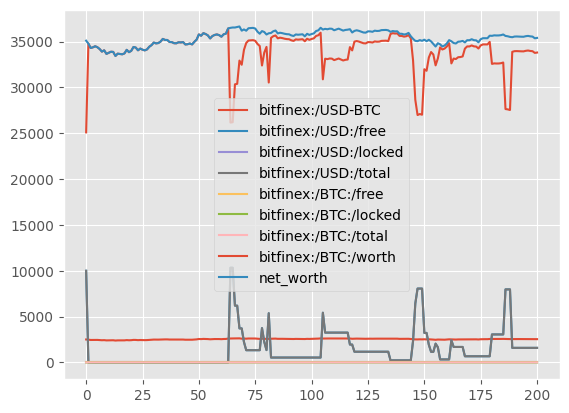

In [15]:
%matplotlib inline

performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance.plot()

<Axes: >

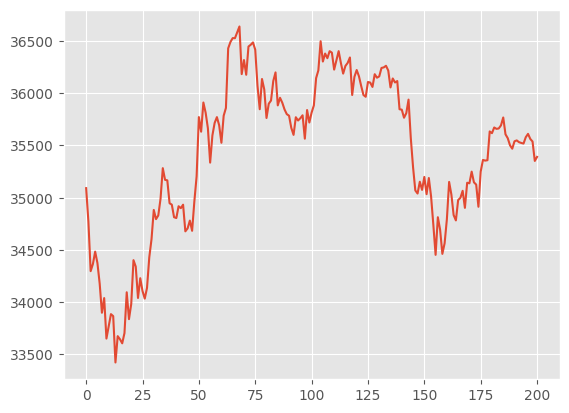

In [16]:
performance.net_worth.plot()